# Yolo Model Fine Tunning

In [3]:
import torch
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## EDA

In [ ]:

IMAGE_DIR = "data\datasets\VisDrone\VisDrone2019-DET-train\images"
LABEL_DIR = "data\datasets\VisDrone\VisDrone2019-DET-train\labels"


In [ ]:


image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))])
label_files = sorted([f for f in os.listdir(LABEL_DIR) if f.endswith('.txt')])

print(f"Total Images: {len(image_files)}")
print(f"Total Label Files: {len(label_files)}")


Total Images: 2499
Total Label Files: 2499


In [ ]:

def read_yolo_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    return [list(map(float, line.strip().split())) for line in lines]

all_labels = []
for lbl_file in label_files:
    annotations = read_yolo_labels(os.path.join(LABEL_DIR, lbl_file))
    all_labels.extend([int(ann[0]) for ann in annotations])

class_counts = Counter(all_labels)
print("Class distribution:", class_counts)


Class distribution: Counter({3: 58414, 0: 36367, 1: 16059, 9: 15194, 4: 8998, 2: 5134, 5: 4809, 6: 3408, 7: 2446, 8: 1642})


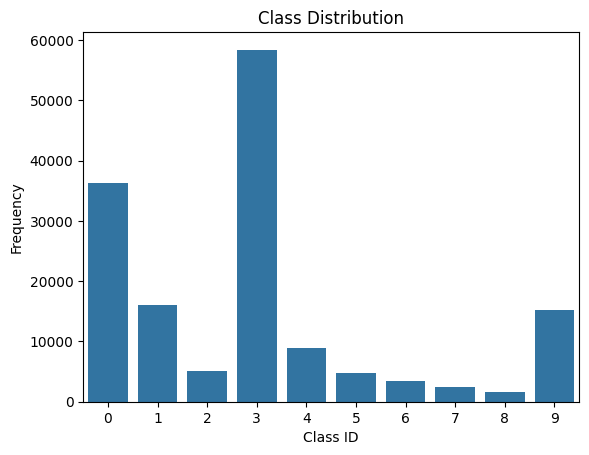

In [ ]:

sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel("Class ID")
plt.ylabel("Frequency")
plt.title("Class Distribution")
plt.show()


Aspect ratio

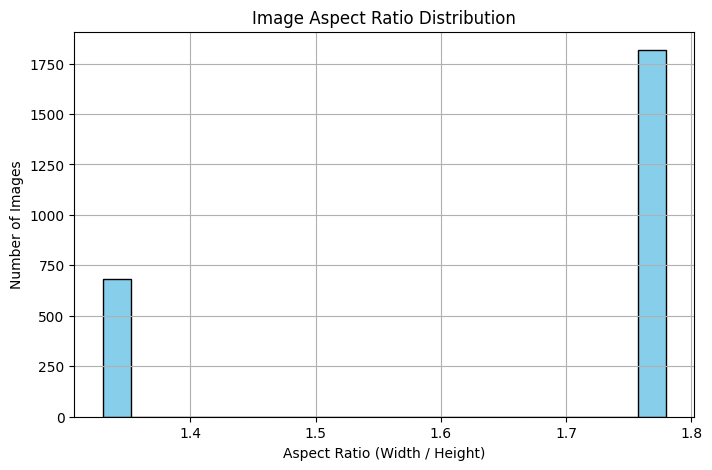

Most common aspect ratios:
Aspect Ratio 1.78: 1817 images
Aspect Ratio 1.33: 682 images


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt



aspect_ratios = []


for filename in os.listdir(IMAGE_DIR):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(IMAGE_DIR, filename)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            if h != 0:
                aspect_ratios.append(round(w / h, 2))


plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Number of Images")
plt.title("Image Aspect Ratio Distribution")
plt.grid(True)
plt.show()


from collections import Counter
print("Most common aspect ratios:")
for ratio, count in Counter(aspect_ratios).most_common(5):
    print(f"Aspect Ratio {ratio}: {count} images")

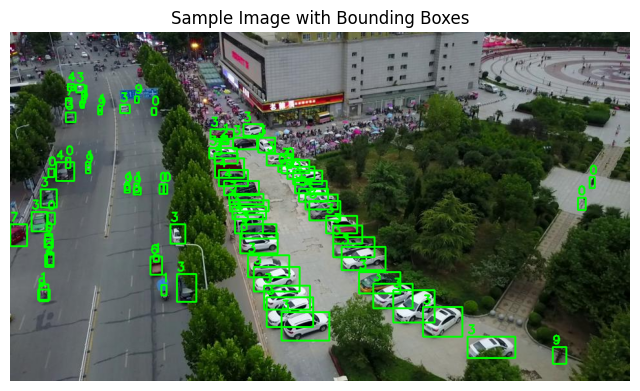

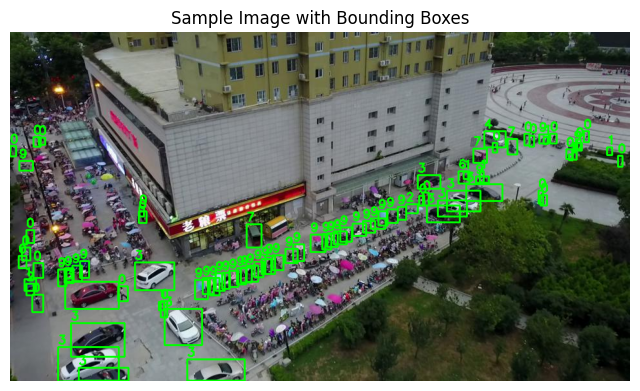

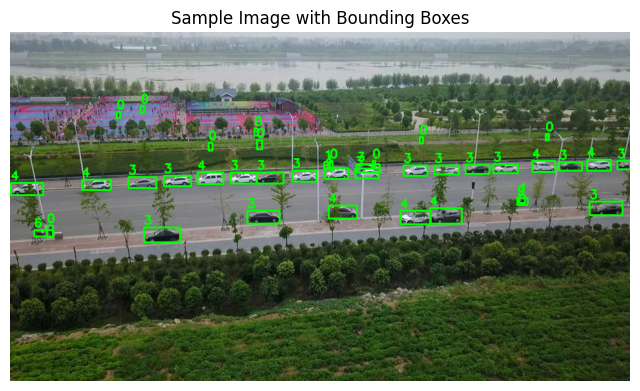

In [ ]:



def draw_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    boxes = read_yolo_labels(label_path)

    for box in boxes:
        class_id, x, y, bw, bh = box
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Sample Image with Bounding Boxes")
    plt.show()

for i in range(3):
    image_path = os.path.join(IMAGE_DIR, image_files[i])
    label_path = os.path.join(LABEL_DIR, image_files[i].replace('.jpg', '.txt').replace('.png', '.txt'))
    draw_boxes(image_path, label_path)

## Train Model

In [ ]:


# Memory allocated by tensors
print(f"Allocated: {torch.cuda.memory_allocated() / 1024 ** 2:.2f} MB")

# Memory reserved by the caching allocator
print(f"Reserved: {torch.cuda.memory_reserved() / 1024 ** 2:.2f} MB")


Allocated: 67.99 MB
Reserved: 134.00 MB


In [4]:
torch.cuda.device_count()

1

In [ ]:
model = YOLO("yolo11l.pt")

In [ ]:
model.train(
    data="D:\Parking_Management_System\data\datasets\VisDrone\VisDrone.yaml",
    batch=16,
    epochs=5,
    imgsz=640,
    verbose=True,
    workers=0,                    # For debugging, use >0 later for speed
    project="runs/train",        # Where results are saved
    name="yolo-visdrone",        # Custom folder name
    save=True,                   # Save weights and logs
    device=0, 
    resume=True,
    save_period=1# Use GPU 0 (or "0,1" for multi-GPU)

)


New https://pypi.org/project/ultralytics/8.3.122 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.121  Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
engine\trainer: task=detect, mode=train, model=runs\train\yolo-visdrone8\weights\best.pt, data=D:/yolo12/datasets_2/VisDrone/VisDrone.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=0, workers=0, project=runs/train, name=yolo-visdrone8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=runs\train\yolo-visdrone8\weights\best.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=Fal

train: Scanning D:\yolo12\datasets_2\VisDrone\VisDrone2019-DET-train\labels.cache... 2499 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2499/2499 [00:00<?, ?it/s]

train: D:\yolo12\datasets_2\VisDrone\VisDrone2019-DET-train\images\0000137_02220_d_0000163.jpg: 1 duplicate labels removed
train: D:\yolo12\datasets_2\VisDrone\VisDrone2019-DET-train\images\0000140_00118_d_0000002.jpg: 1 duplicate labels removed
train: D:\yolo12\datasets_2\VisDrone\VisDrone2019-DET-train\images\9999945_00000_d_0000114.jpg: 1 duplicate labels removed
val: Fast image access  (ping: 0.10.0 ms, read: 18.64.8 MB/s, size: 142.1 KB)



val: Scanning D:\yolo12\datasets_2\VisDrone\VisDrone2019-DET-val\labels.cache... 548 images, 0 backgrounds, 0 corrupt: 100%|██████████| 548/548 [00:00<?, ?it/s]


Plotting labels to runs\train\yolo-visdrone8\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Resuming training runs\train\yolo-visdrone8\weights\best.pt from epoch 3 to 5 total epochs
Closing dataloader mosaic
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\train\yolo-visdrone8
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      12.6G      1.548      1.257      1.067        188        640: 100%|██████████| 157/157 [1:21:19<00:00, 31.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [08:02<00:00, 26.80s/it]

                   all        548      38759       0.37      0.274      0.253       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      12.7G      1.471      1.156      1.012        127        640: 100%|██████████| 157/157 [43:33<00:00, 16.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [04:59<00:00, 16.64s/it]

                   all        548      38759      0.388      0.286       0.27      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      10.4G      1.416       1.08     0.9937        164        640: 100%|██████████| 157/157 [56:00<00:00, 21.41s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [04:29<00:00, 14.95s/it]

                   all        548      38759      0.412      0.309      0.299      0.167



3 epochs completed in 3.310 hours.
Optimizer stripped from runs\train\yolo-visdrone8\weights\last.pt, 19.2MB
Optimizer stripped from runs\train\yolo-visdrone8\weights\best.pt, 19.2MB

Validating runs\train\yolo-visdrone8\weights\best.pt...
Ultralytics 8.3.121  Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 SUPER, 6144MiB)
YOLO11s summary (fused): 100 layers, 9,416,670 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]


                   all        548      38759      0.413      0.309      0.299      0.168
            pedestrian        520       8844      0.447      0.336      0.341       0.15
                people        482       5125      0.671      0.108      0.245     0.0867
               bicycle        364       1287      0.267     0.0886     0.0848     0.0339
                   car        515      14064      0.595      0.713      0.712      0.481
                   van        421       1975      0.371      0.369       0.32      0.217
                 truck        266        750      0.264      0.351      0.256      0.156
              tricycle        337       1045      0.349      0.211      0.189      0.103
       awning-tricycle        220        532      0.257      0.111     0.0969       0.06
                   bus        131        251      0.538      0.398      0.402      0.249
                 motor        485       4886      0.373      0.407      0.346      0.139
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C33088F7F0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

# Parking Management

Detecting System

In [14]:
import cv2

from ultralytics import solutions



# Video capture
cap = cv2.VideoCapture("data/Top view footage of the parking lot.mp4")
assert cap.isOpened(), "Error reading video file"

# Video writer
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
video_writer = cv2.VideoWriter("parking management.avi", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# Initialize parking management object
parkingmanager = solutions.ParkingManagement(
    model="runs/train/yolo-visdrone/weights/best.pt",  # path to model file
    json_file="bounding_boxes.json",  # path to parking annotations file
)

while cap.isOpened():
    ret, im0 = cap.read()
    if not ret:
        break
 
    results = parkingmanager(im0)

    cv2.imshow('Video Playback', results.plot_im)
     # Press 'q' to quit early
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # print(results)  # access the output

    video_writer.write(results.plot_im)  # write the processed frame.

cap.release()
# video_writer.release()
cv2.destroyAllWindows()  # destroy all opened windows

Ultralytics Solutions:  {'region': None, 'show_in': True, 'show_out': True, 'colormap': None, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'json_file': 'bounding_boxes.json', 'records': 5, 'model': 'runs/train/yolo-visdrone/weights/best.pt'}



0: 384x640 29 cars, 2 vans, 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
 Results: SolutionResults(available_slots=10, filled_slots=25, total_tracks=31)

0: 384x640 29 cars, 2 vans, 10.2ms
Speed: 1.7ms preprocess, 10.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
 Results: SolutionResults(available_slots=10, filled_slots=25, total_tracks=31)

0: 384x640 28 cars, 2 vans, 10.0ms
Speed: 1.5ms preprocess, 10.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
 Results: SolutionResults(available_slots=10, filled_slots=25, total_tracks=30)

0: 384x640 29 cars, 2 vans, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
 Results: SolutionResults(available_slots=10, filled_slots=25, total_tracks=31)

0: 384x640 29 cars, 2 vans, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
 Results: SolutionR

Reviewing Saved Video

In [20]:
import cv2

parking_management= 'parking management.avi'
# Path to your video file
video_path = 'data/Top view footage of the parking lot.mp4'  # Replace with your actual video path
cap = cv2.VideoCapture(parking_management)

# Check if the video was opened correctly
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Read and display frames in a loop
while True:
    ret, frame = cap.read()

    if not ret:
        print("Reached end of video or error occurred.")
        break

    # Display the frame
    cv2.imshow('Video Playback', frame)

    # Press 'q' to quit early
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
